In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
import os
import random

import pytorch3d
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from syncmatch.models.synchronization import (
    camera_chaining,
    camera_synchronization,
    camera_synchronization_eig,
)
from syncmatch.utils.metrics import evaluate_multiview_Rt
from syncmatch.utils.transformations import (
    SE3_inverse,
    get_relative_Rt,
    make_Rt,
    random_Rt,
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def generate_N_views(batch, N):
    Rs = pytorch3d.transforms.random_rotations(batch * N)
    Rs = Rs.view(batch, N, 3, 3).contiguous()
    ts = torch.randn(batch, N, 3) * 10
    return make_Rt(Rs, ts)


def generate_pairwise_dictionary(P, noise_R=0, noise_t=0, dropout=0.0):
    batch_size, N, _, _ = P.shape

    pw_P, conf = {}, {}
    for i in range(N):
        for j in range(i + 1, N):
            rel_P = get_relative_Rt(P[:, i], P[:, j])
            if noise_R > 0 or noise_t > 0:
                noise_P = random_Rt(batch_size, noise_R, noise_t).to(rel_P)
                rel_P = torch.bmm(noise_P, rel_P)

            if torch.rand(1).item() < dropout and abs(i - j) > 1:
                rel_P[:, :3, :3] = torch.eye(3).to(rel_P)
                rel_P[:, :3, 3] = 0
                conf[(i, j)] = torch.zeros(batch_size).to(P)
            else:
                pw_P[(i, j)] = rel_P
                conf[(i, j)] = torch.ones(batch_size).to(P)

    return pw_P, conf


def benchmark_sync_method(sync_method, batch_size, N, noise_R, noise_t, dropout):
    # Generate N views
    gt_P = generate_N_views(batch_size, N)
    gt_P = gt_P.cuda().float()
    pw_P, conf = generate_pairwise_dictionary(gt_P, noise_R, noise_t, dropout)

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    pr_P = sync_method(pw_P, conf, N)
    end.record()

    # Waits for everything to finish running
    torch.cuda.synchronize()
    elapsed_time = start.elapsed_time(end)

    error_P = evaluate_multiview_Rt(pr_P, gt_P)
    error_R = error_P["vp-error_R"].mean()
    error_t = error_P["vp-error_t"].mean()

    return elapsed_time, error_R, error_t

In [28]:
# BLOCK FOR TRANSLATION ERROR
batch_size = 8
print("=" * 97)
print(
    f"{'method':30s} | drop |  N  | noise R | noise t | time (ms) |",
    "error R | error t |",
)
print("-" * 97)

N = 4
dropout = 0

result_dict = {}

d_R = 0
d_t = 0

d_t_range = np.array([0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30])
d_R_range = np.array([0, 5, 10, 15, 20, 25, 30])

result_dict = {"method": [], "Noise (cm)": [], "Noise (deg)": [], "Error (deg)": [], "Error (cm)": []}
    

methods = {
    "Ours": camera_synchronization,
    "Gojcic et al.": camera_synchronization_eig,
    "Naive Sync.": camera_chaining,
}

result_dict_t = {"method": [], "Noise (cm)": [], "Noise (deg)": [], "Error (deg)": [], "Error (cm)": [], "Num Views": []}
for N in [4, 8, 16, 32, 64]:
    for method in methods:
        for d_t in d_t_range:
            for d_R in [0, ]:
                benchmark_sync_method(methods[method], batch_size, N, d_R, d_t, dropout)
                time, errR, errt = [], [], []
                num_iterations = 1

                for i in range(num_iterations):
                    time_i, errR_i, errt_i = benchmark_sync_method(
                        methods[method], batch_size, N, d_R, d_t, dropout
                    )
                    time.append(time_i)
                    errR.append(errR_i.item())
                    errt.append(errt_i.item())

                    result_dict_t["method"].append(method)
                    result_dict_t["Noise (deg)"].append(d_R)
                    result_dict_t["Noise (cm)"].append(d_t * 100)
                    result_dict_t["Error (deg)"].append(errR_i.item())
                    result_dict_t["Error (cm)"].append(errt_i.item())

                time = np.array(time)
                errR = np.array(errR)
                errt = np.array(errt)

                print(
                    f"{method:30s} | {dropout:4.2f} | {N:3d} |",
                    f"{d_R:3d} deg | {d_t:5.2f} m |",
                    f"{time.mean():9.2f} | {errR.mean():7.2f} | {errt.mean():7.2f} |",
            )
print("=" * 97)


result_dict_R = {"method": [], "Noise (cm)": [], "Noise (deg)": [], "Error (deg)": [], "Error (cm)": [], "Num Views": [], "Time (s)": []}
for N in [4, 8, 16, 32, 64]:
    for method in methods:
        d_t = 0
        for d_R in d_R_range:
            benchmark_sync_method(methods[method], batch_size, N, d_R, d_t, dropout)
            time, errR, errt = [], [], []
            num_iterations = 1

            for i in range(num_iterations):
                time_i, errR_i, errt_i = benchmark_sync_method(
                    methods[method], batch_size, N, d_R, d_t, dropout
                )
                time.append(time_i / 1000.0)
                errR.append(errR_i.item())
                errt.append(errt_i.item())

                result_dict_R["method"].append(method)
                result_dict_R["Num Views"].append(N)
                result_dict_R["Noise (deg)"].append(d_R)
                result_dict_R["Noise (cm)"].append(d_t * 100)
                result_dict_R["Error (deg)"].append(errR_i.item())
                result_dict_R["Error (cm)"].append(errt_i.item())
                result_dict_R["Time (s)"].append(time_i / 1000)

            time = np.array(time)
            errR = np.array(errR)
            errt = np.array(errt)

            print(
                f"{method:30s} | {dropout:4.2f} | {N:3d} |",
                f"{d_R:3d} deg | {d_t:5.2f} m |",
                f"{time.mean():9.2f} | {errR.mean():7.2f} | {errt.mean():7.2f} |",
            )
print("=" * 97)

del result_dict_t["Num Views"]

method                         | drop |  N  | noise R | noise t | time (ms) | error R | error t |
-------------------------------------------------------------------------------------------------
Ours                           | 0.00 |   4 |   0 deg |  0.00 m |      2.91 |    0.01 |    0.00 |
Ours                           | 0.00 |   4 |   0 deg |  0.05 m |      2.67 |    0.01 |    1.93 |
Ours                           | 0.00 |   4 |   0 deg |  0.10 m |      2.68 |    0.01 |    3.97 |
Ours                           | 0.00 |   4 |   0 deg |  0.15 m |      2.68 |    0.01 |    5.79 |
Ours                           | 0.00 |   4 |   0 deg |  0.20 m |      2.77 |    0.01 |    7.62 |
Ours                           | 0.00 |   4 |   0 deg |  0.25 m |      2.80 |    0.01 |    8.82 |
Ours                           | 0.00 |   4 |   0 deg |  0.30 m |      2.77 |    0.01 |   11.71 |
Gojcic et al.                  | 0.00 |   4 |   0 deg |  0.00 m |      4.07 |    0.02 |    0.00 |
Gojcic et al.       

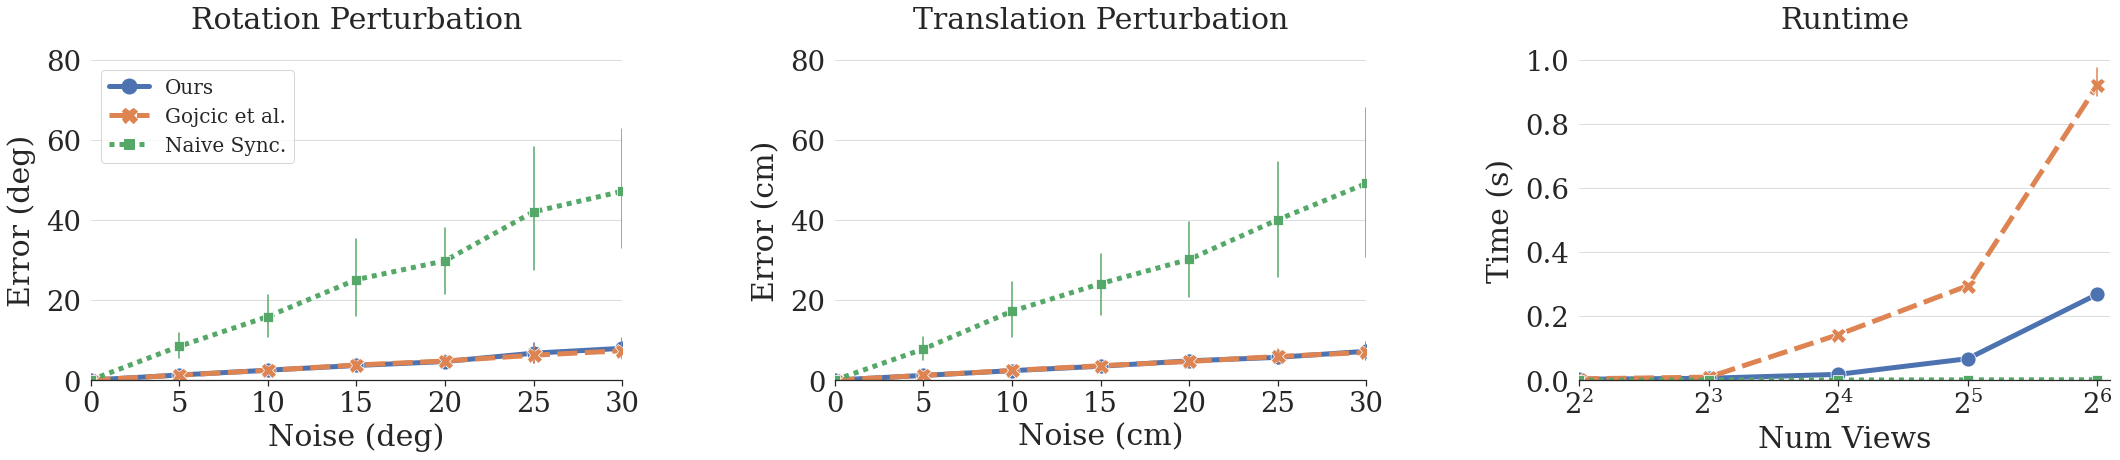

In [93]:
## import pandas 

font_scale = 2.5
linewidth = font_scale * 2
markersize = font_scale * 6


sns.set(font_scale=font_scale)
sns.set_style(
    "ticks",
    {
        "ytick.left": False,
        "font.family": ["serif"],
        "font.serif": ["Times New Roman"],
    }
)


dft = pandas.DataFrame(result_dict_t)
dfR = pandas.DataFrame(result_dict_R)


fig, axes = plt.subplots(1, 3, figsize=(30, 6))
fig.tight_layout()

ax = sns.lineplot(ax=axes[0], x="Noise (deg)", y="Error (deg)", hue="method", data=dfR, markers=True, style="method", err_style="bars", estimator=np.mean, ci=90, linewidth=linewidth,markersize=markersize)

handles, labels = ax.get_legend_handles_labels()

lgnd = ax.legend(
    handles=handles[0:], labels=labels[0:], 
    prop={'size': font_scale * 8},
    loc="upper left",
)


for lh in lgnd.legendHandles:
    lh.set_markersize(markersize)
    lh.set_linewidth(linewidth)
    
ax = sns.lineplot(ax=axes[1], x="Noise (cm)", y="Error (cm)", hue="method", data=dft, markers=True, style="method", err_style="bars", estimator=np.mean, ci=90, legend=False, linewidth=linewidth,markersize=markersize)
ax = sns.lineplot(ax=axes[2], x="Num Views", y="Time (s)", hue="method", data=dfR, markers=True, style="method", err_style="bars", estimator=np.mean, ci=90, legend=False, linewidth=linewidth,markersize=markersize)
ax.set_xscale('log', base=2)
# ax.set_yscale('log', base=10)


title_scale = 12
title_yoff = 1.08
axes[0].set_title("Rotation Perturbation", fontsize=font_scale * title_scale, y=title_yoff)
axes[1].set_title("Translation Perturbation", fontsize=font_scale * title_scale, y=title_yoff)
axes[2].set_title("Runtime", fontsize=font_scale * title_scale, y=title_yoff)

plt.subplots_adjust(hspace=0.4, wspace=0.4)

axes[0].yaxis.grid(True, color="gainsboro")
axes[1].yaxis.grid(True, color="gainsboro")
axes[2].yaxis.grid(True, color="gainsboro")

axes[0].set_xlim(0, 30)
axes[1].set_xlim(0, 30)
axes[2].set_xlim(2**2, 2**6.1)
axes[0].set_ylim(0, 80)
axes[1].set_ylim(0, 80)
axes[2].set_ylim(0, 1)
axes[0].yaxis.labelpad = 10
axes[1].yaxis.labelpad = 10
axes[2].yaxis.labelpad = 10

axes[0].xaxis.labelpad = 6
axes[1].xaxis.labelpad = 6
axes[2].xaxis.labelpad = 6
        


sns.despine(top=True, right=True, left=True)